In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

In [13]:
df = pd.read_csv('bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv')
df = df.dropna(how='any',axis=0) # removes rows with null values
df.isnull().values.any() # check to see if null values exist

False

In [18]:
df.shape

(2765819, 9)

In [14]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [17]:
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Daily_Price = group['Weighted_Price'].mean()

Daily_Price.head()

date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.208159
Name: Weighted_Price, dtype: float64

In [19]:
Daily_Price.tail()

date
2019-08-08    11801.348742
2019-08-09    11819.342193
2019-08-10    11578.771029
2019-08-11    11378.232876
2019-08-12    11540.450291
Name: Weighted_Price, dtype: float64

In [22]:
from datetime import date
d0 = date(2011, 12, 31)
d1 = date(2016, 10, 15)
delta = d1 - d0
days_look = delta.days + 1
print(days_look)

d0 = date(2019, 6, 12)
d1 = date(2019, 8, 12)
delta = d1 - d0
days_from_train = delta.days + 1
print(days_from_train)

d0 = date(2019, 8, 7)
d1 = date(2019, 8, 12)
delta = d1 - d0
days_from_end = delta.days + 1
print(days_from_end)

1751
62
6


### Now Split the data

In [21]:
df_train= Daily_Price[len(Daily_Price)-days_look-days_from_end:len(Daily_Price)-days_from_train]
df_test= Daily_Price[len(Daily_Price)-days_from_train:]

print(len(df_train), len(df_test))

(1695, 62)


## Exploratory Analysis

In [23]:
working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['date'])
working_data = working_data.set_index('date')

In [24]:
s = sm.tsa.seasonal_decompose(working_data.Weighted_Price.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')

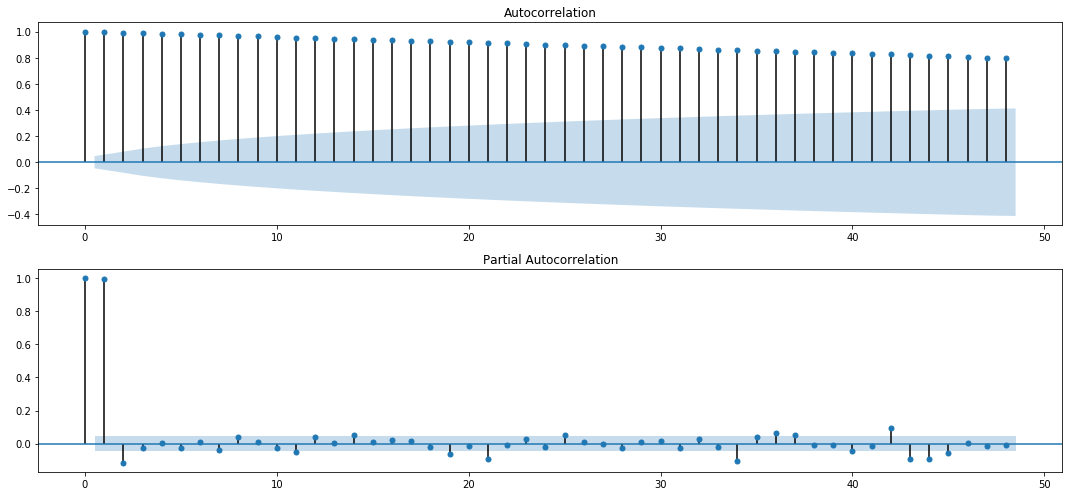

In [25]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(working_data.Weighted_Price.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [26]:
df_train = working_data[:-60]
df_test = working_data[-60:]

## Data Preparation

In [27]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [28]:
from sklearn.preprocessing import MinMaxScaler

training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

## Training 2-layers LSTM Neural Network

In [29]:

# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1696 samples, validate on 59 samples
Epoch 1/100
1696/1696 [==============================] - 7s 4ms/step - loss: 0.0061 - val_loss: 0.0950
Epoch 2/100
1696/1696 [==============================] - 4s 2ms/step - loss: 0.0150 - val_loss: 0.0854
Epoch 3/100
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0138 - val_loss: 0.0588
Epoch 4/100
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0092 - val_loss: 0.0429
Epoch 5/100
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0050 - val_loss: 0.0262
Epoch 6/100
1696/1696 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 7/100
1696/1696 [==============================] - 4s 2ms/step - loss: 8.4209e-04 - val_loss: 0.0041
Epoch 8/100
1696/1696 [==============================] - 4s 2ms/step - loss: 3.1501e-04 - val_loss: 0.0016
Ep

In [37]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [51]:
# add one additional data point to align shapes of the predictions and true labels
X_test = np.append(X_test, scaler.transform(working_data.iloc[-1][0]))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

ValueError: Expected 2D array, got scalar array instead:
array=11540.450291.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [45]:

trace1 = go.Scatter(
    x = np.arange(0, len(prediction2_inverse), 1),
    y = prediction2_inverse,
    mode = 'lines',
    name = 'Predicted price',
    hoverlabel= dict(namelength=-1),
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)
trace2 = go.Scatter(
    x = np.arange(0, len(Y_test2_inverse), 1),
    y = Y_test2_inverse,
    mode = 'lines',
    name = 'True price',
    line = dict(color=('rgb(66, 244, 155)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Comparison of true prices (on the test dataset) with prices our model predicted',
             xaxis = dict(title = 'Day number'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='results_demonstrating0')